In [9]:
%matplotlib inline

In [10]:
import matplotlib.pyplot as plt
import numpy
from collections import defaultdict
import importlib
import pprint

from interval import interval

import screed

import alignplot
importlib.reload(alignplot)

from alignplot import StackedDotPlot

## another tara genome, this time with two contaminants

In [11]:
if 0:
    dotplot = StackedDotPlot('TARA_PSE_MAG_00132', ('GCA_001550135.1', 'GCA_001641615.1'),
                             'list.csv', './genomes', use_mashmap=True)

In [12]:
if 0:
    dotplot = StackedDotPlot('TARA_ANW_MAG_00083', ('GCA_002171995.1',),
                             'list.csv', './genomes', use_mashmap=True)

In [13]:
if 0:
    dotplot = StackedDotPlot('GCA_001550135.1', ('TARA_PSE_MAG_00132', 'GCA_001641615.1'),
                             'list.csv', './genomes', use_mashmap=True)

In [14]:
if 1:
    dotplot = StackedDotPlot('GCA_003220225.1',
                             ['GCA_003222275.1',],
                             'list.csv', './genomes', use_mashmap=True)
    
if 0:
    dotplot2 = StackedDotPlot('GCA_003222275.1',
                             ['GCA_003220225.1'],
                             'list.csv', './genomes')

['./genomes/GCA_003220225.1_ASM322022v1_genomic.fna']
found queryfile for GCA_003220225.1: ./genomes/GCA_003220225.1_ASM322022v1_genomic.fna
found targetfile for GCA_003222275.1: ./genomes/GCA_003222275.1_ASM322227v1_genomic.fna


In [15]:
if 0:
    dotplot = StackedDotPlot('GCA_003222275.1',
                         ['GCA_003222275.1',],
                         'list.csv', './genomes', use_mashmap=False)

## Stacked DotPlot view

(this is an n-ary dotplot)

running mashmap...
running mashmap -q ./genomes/GCA_003220225.1_ASM322022v1_genomic.fna -r ./genomes/GCA_003222275.1_ASM322227v1_genomic.fna -o /var/folders/y6/s1r3q87933s6gjdrtmts1npc0000gq/T/tmp30xlrmv3/mashmap.out --pi 95
...done! reading output from /var/folders/y6/s1r3q87933s6gjdrtmts1npc0000gq/T/tmp30xlrmv3/mashmap.out.
shared w/Acidobacteria bacterium: 775.5kb


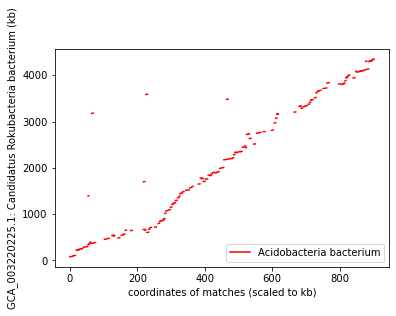

In [16]:
_ = dotplot()

## region response curve

underlying logic:

* for our primary use case here (contamination/legitimate "shared" nucleotides), we can consider nt alignments of >= 95% to be contamination to be removed
* we want to remove as many bp of contamination as possible with as little "legit" non-shared nt as possible.
* what's the response curve for that, and can we use it to figure out which genome(s) have the likely contaminants?

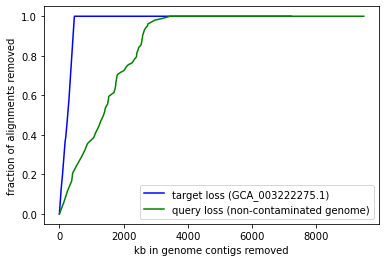

In [17]:
t_acc = dotplot.t_acc_list[0]
x, y, sat1 = dotplot.target_response_curve(t_acc)

x3, y3, sat3 = dotplot.query_response_curve()

plt.plot(x, y / max(y), 'b-', label=f'target loss ({t_acc})')
plt.plot(x3, y3 / max(y3), 'g-', label='query loss (non-contaminated genome)')

plt.xlabel('kb in genome contigs removed')
plt.ylabel('fraction of alignments removed')
plt.legend(loc='lower right')
plt.savefig('/tmp/acido-target.png')
#print(sat1, sat2)